[View in Colaboratory](https://colab.research.google.com/github/asonabend/Phenotype_prediction/blob/master/iterative_beta_and_theta.ipynb)

In [0]:

# Code to read csv file into colaboratory:
!pip install -U -q PyDrive
import tensorflow as tf
import numpy as np
import pandas as pd
from numpy import linalg as LA
import matplotlib.pyplot as plt
from sklearn import metrics
from scipy.special import expit


In [2]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

#2a. Get the file
downloaded = drive.CreateFile({'id':'1fupXX3KJWTbdI7MLPHKbDyEDKAXCzO7a'}) # replace the id with id of file you want to access
downloaded.GetContentFile('raprod2.ra.full.csv')  
#3a. Read file as panda dataframe
dat_pop = pd.read_csv('raprod2.ra.full.csv') 

#2b. Get the file
downloaded = drive.CreateFile({'id':'1Igod8k0utRAqgK4BeEuZqj31JCURQQ5K'}) 
downloaded.GetContentFile('cui2vec_RAsubset.csv')  
#3b. Read file as panda dataframe
cui_subset = pd.read_csv('cui2vec_RAsubset.csv') 

#2c. Get the file
downloaded = drive.CreateFile({'id':'1Z8YK2sVwKeA0OsZQV-sMNeFSkAI0zX02'}) 
downloaded.GetContentFile('C1858558.csv')  
#3c. Read file as panda dataframe
C1858558 = pd.read_csv('C1858558.csv') 


/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [58]:
# Convert to matrix and remove unnamed column:
np_C0003873 = cui_subset.loc[cui_subset[list(cui_subset)[0]] == 'C0003873'].values
np_C0003873 = np.delete(np_C0003873,0,1)#.flatten()

np_cui_subset = cui_subset.loc[:, ~cui_subset.columns.str.contains('^Unnamed')].as_matrix()


# Select top 10 percent:
# Calculates cosine similarities:
np_cos_sim = ([np_C0003873.dot(np_cui_subset[i,:])/(LA.norm(np_cui_subset[i,:])) for i in range(np_cui_subset.shape[0])]/LA.norm(np_C0003873))
np_cos_sim = np_cos_sim/sum(np_cos_sim)
close_CUIs = (abs(np_cos_sim) > np.percentile(abs(np_cos_sim),90)).flatten()
np_cui_subset = np_cui_subset[close_CUIs,:]

# Create tensorflow constants for RA CUI 
#tf_C1858558 = tf.constant(np_C1858558,name='RAcui', dtype=tf.float32)


# Calculates cosine similarities:
np_cos_sim = ([np_C0003873.dot(np_cui_subset[i,:])/(LA.norm(np_cui_subset[i,:])) for i in range(np_cui_subset.shape[0])]/LA.norm(np_C0003873))
np_cos_sim = np_cos_sim/sum(np_cos_sim)

### First I filter the non-labeled rows then I filter the CUI's not mentioned in the notes
counts = dat_pop.loc[dat_pop['label'].isin(['Y','N'])].loc[:,list(cui_subset.iloc[close_CUIs,0])].as_matrix()
# Patients response::
y = dat_pop.loc[dat_pop['label'].isin(['Y','N'])].loc[:,'label'].eq('Y').mul(1).as_matrix()


### Define test sample of size test_perc*patients_No ###
np.random.seed(116687)
test_perc = .1
test_index = np.random.choice(len(y),replace=False, size=round(test_perc*len(y)))
test_y = y[test_index]
test_counts = counts[test_index,:]


### Define training sample with the rest to the observations ###
y = np.delete(y, test_index, 0)
counts = np.delete(counts, test_index, 0)
 

(820, 500)


In [71]:
# for FDR
#[k*.05/np_cui_subset.shape[0] for k in range(np_cui_subset.shape[0])]
BH_FDR = [k*.05/820 for k in range(820)]
p_vals = [p/820 for p in range(820)]
[p_vals[k] <= BH_FDR[k] for k in range(820)]
np.percentile(abs(np_cos_sim),90)


0.017619314936840713

In [0]:
### Iterative regression function ###
#####################################
# Inputs:
## y = binary vector containing disease status, type: numpy.ndarray
## counts = matrix with patients as rows and counts of the j^th column mentioned in the i^th patient note at (i,j), type: numpy.ndarray
## vec_weights = normalized weight vector of size CUIs_No (number of CUIs to be used), type: numpy.ndarray
## cui_subset = CUI-embedding matrix with CUIs as rows and dimensions as columns, type: numpy.ndarray
## OPTIONAL PARAMETERS:
## val_perc = number between (0,1) to determine the percentage of sample for validation, type: 
## reg_type = Select appropriate loss function based on regression type: either Ridge or LASSO
## tot_iters = Total iterations for the regression paramaters loop
def it_reg(y,counts=counts,
           vec_weights=np_cos_sim,
           cui_subset=np_cui_subset,
           val_perc = 0.15,        
           reg_type='Ridge',
           lambda_theta=1.,
           lambda_beta=1.,
           step_theta=1e-1,
           step_beta=1e-1,
           tot_iters=1500):
  
### Define validation sample of size val_perc*patients_No ###
  val_index = np.random.choice(len(y),replace=False, size=round(val_perc*len(y)))
  val_y = y[val_index]
  val_counts = counts[val_index,:]
  
### Define training sample with the rest to the observations ###
  y = np.delete(y, val_index, 0)
  counts = np.delete(counts, val_index, 0)
  
  # Clear out old graph
  tf.reset_default_graph()
  # Create graph
  sess = tf.Session()
  
### Data manipulation ###
  
  # Create tensorflow constant for the CUI matrix
  tf_cui_subset = tf.constant(cui_subset,name='CUIsubset', dtype=tf.float32)

  # Create tensorflow constants the cosine similarities
  tf_cos_sim = tf.constant(vec_weights,name='cos_sim', dtype=tf.float32)
  # X matrix which contains X_ij, the count of CUI j in patient's i notes:
  X = counts.transpose()# Not centered anymore since I use log instead of x^2 (counts-counts.mean()).as_matrix().transpose()
  # Count transformations, currently using x, log(x+1) and sqrt(x) # check to see if a NN to estimate optimal tranformation improves result or it's too unstable
  np_X_poly = np.array([[X[cui,:],np.log(X[cui,:]+1),np.sqrt(X[cui,:])] for cui in range(X.shape[0])])#np.array([[np.ones(X.shape[1]),X[cui,:],np.square(X[cui,:])] for cui in range(X.shape[0])])
  ### Now I convert it to a tensorflow constant:
  tf_X_poly = tf.constant(np_X_poly,name='CUIcounts', dtype=tf.float32)#,shape=np_X_poly.shape

  

### Model Parameters ###


  # Declare batch size
  batch_size = counts.shape[0] ####### is this necessary now?

  # Matrix Dimensions:
  CUIs_No, CUIs_dim = cui_subset.shape
  seed = 116687
  patients_No = counts.shape[0]
  theta_dim = np_X_poly.shape[1]
  
### Generates cosine sim. weighted CUI-embedding matrix ###
  Vw = tf.multiply(tf_cui_subset,tf_cos_sim)
  # Turn it into a 3D tensor for multiplications later:
  Vw = tf.expand_dims(Vw, axis=0)
  # Replicate the Weighted word-vec matrix for evey patient:
  Vws = tf.tile(Vw,[patients_No,1,1])

### Initializes TensorFlow parameters ###
  ### theta such that f_j(x_ij)=theta0_j+theta1_j*X_ij+theta2_j*(X_ij)^2:
  theta = tf.Variable(tf.random_normal(shape=[CUIs_No,1,theta_dim]),name='theta')
  ### beta for regression:
  beta = tf.Variable(tf.random_normal(shape=[CUIs_dim,1]),name='beta')
  beta0 = tf.Variable(tf.random_normal(shape=[1,1]),name='beta0')
  # Initialize placeholders
  z_data = tf.placeholder(shape=[None, CUIs_dim], dtype=tf.float32)
  y_target = tf.placeholder(shape=[None, 1], dtype=tf.float32)
  beta_const = tf.placeholder(shape=[CUIs_dim,1], dtype=tf.float32,name='beta_const')
  beta0_const = tf.placeholder(shape=[1,1], dtype=tf.float32,name='beta0_const')
  
### Declares model operations ####
## Calculate f_j(x)=theta0j*x_ij+theta1j*log(x_ij+1)+theta2j*sqrt(x_ij) where j is a CUI
  f_x = tf.transpose(tf.matmul(theta,tf_X_poly)) # tensor dimensions: (patiens_No,1,CUI_No)
## Cosine sim. weighted CUI-embedding matrix:
## Patient's feature vectors:
  tf_z = tf.squeeze(tf.matmul(f_x,Vws))
  model_output_beta = tf.sigmoid(tf.add(tf.matmul(z_data, beta), beta0))
  model_output_theta = tf.sigmoid(tf.add(tf.matmul(tf_z, beta_const), beta0_const))
  
### Loss Functions ###

# Loss functions to optimize over beta: ### Lasso is not implemented yet
#regression_type = 'LASSO'
  regression_type = 'Ridge'

# Select appropriate loss function based on regression type
  if reg_type == 'LASSO':

    lasso_param = tf.constant(0.9)
    heavyside_step = tf.truediv(1., tf.add(1., tf.exp(tf.multiply(-50., tf.subtract(beta, lasso_param)))))
    regularization_param = tf.multiply(heavyside_step, 99.)
    loss_beta = tf.add(tf.reduce_mean(tf.square(y_target - model_output_beta)), regularization_param)

  elif reg_type == 'Ridge':
# Declare the Ridge loss function
## Ridge loss = L2_loss + L2 norm of slope
    ridge_param = tf.constant(lambda_beta)
    ridge_loss = tf.reduce_mean(tf.square(beta))
    loss_beta = tf.expand_dims(tf.add(tf.reduce_mean(tf.square(y_target - model_output_beta)), tf.multiply(ridge_param, ridge_loss)), 0)
  
# Loss functions to optimize over theta

## Regularization for theta:
  theta_param = tf.constant(lambda_theta)
  theta_reg_loss = tf.reduce_mean(tf.square(theta))
  loss_theta = tf.expand_dims(tf.add(tf.reduce_mean(tf.square(y_target - model_output_theta)), tf.multiply(theta_param, theta_reg_loss)), 0)
  

### Optimizers ###

# Declare optimizers
  my_opt_beta = tf.train.GradientDescentOptimizer(step_beta)
  train_step_beta = my_opt_beta.minimize(loss_beta)

  #tf.train.AdamOptimizer(1e-4).minimize(cross_entropy) ### might be better than SGD
  my_opt_theta = tf.train.GradientDescentOptimizer(step_theta)
  train_step_theta = my_opt_theta.minimize(loss_theta)

### Runs regression: ###
# make results reproducible
  np.random.seed(seed)
  tf.set_random_seed(seed)

# Initialize variables
  init = tf.group(tf.global_variables_initializer(), tf.local_variables_initializer())
  sess.run(init)
  np_Z = sess.run(tf_z)
# Training loop
  loss_vec, trainAUC_vec, valAUC_vec = [],[],[]
  for i in range(tot_iters):
      rand_index = np.random.choice(np_Z.shape[0], size=batch_size,replace=False)
      rand_z = np_Z[rand_index,:]
      rand_y = np.array([y[rand_index]]).transpose()
      sess.run(train_step_beta, feed_dict={z_data: rand_z, y_target: rand_y})
      ##
      np_beta = sess.run(beta)
      np_beta0 = sess.run(beta0)
      y_pred = expit(rand_z.dot(np_beta)+np_beta0)
      sess.run(train_step_theta, feed_dict={beta_const: np_beta, beta0_const: np_beta0, y_target: rand_y})
      rand_z = sess.run(tf_z)
      ##
      temp_loss = sess.run(loss_beta, feed_dict={z_data: rand_z, y_target: rand_y})
      val_y_preds = predict(counts=val_counts,vec_weights=vec_weights,cui_subset=cui_subset,theta=sess.run(theta),beta=np_beta,beta0=np_beta0)
      temp_valAUC = metrics.roc_auc_score(val_y, val_y_preds)
      temp_trainAUC = metrics.roc_auc_score(rand_y, y_pred)
      loss_vec.append(temp_loss[0])
      valAUC_vec.append(temp_valAUC)
      trainAUC_vec.append(temp_trainAUC)
      
      #if (i+1)%1500==0 or i == 0:
      #  print('Step #' + str(i+1) + ' beta = ' + str(sess.run(beta)[0]) + ' beta0 = ' + str(sess.run(beta0)) + ' theta = ' + str(sess.run(theta[0,0])))
      #  print('Loss = ' + str(temp_loss))
      #  print('training AUC = ' + str(temp_valAUC))
      #  print('validation AUC = ' + str(temp_trainAUC))
      #  print('\n')
 

### Extract regression results: ###

  results = {'beta0': np_beta0, 'beta': np_beta, 'theta': sess.run(theta),'auc': metrics.roc_auc_score(rand_y, y_pred),
             'Loss': loss_vec, 'valAUC':valAUC_vec, 'trainAUC':trainAUC_vec}
  
### Plots loss over time: ###
  plt.plot(loss_vec, 'k-')
  #plt.plot(range(tot_iters), loss_vec, 'k-', range(tot_iters), valAUC_vec, 'bs', range(tot_iters), trainAUC_vec, 'g^')
  plt.title('regression_type' + ' Loss per Generation')
  plt.xlabel('Generation')
  plt.ylabel('Loss')
  plt.show()
  return(results)

###########################
### Prediction function ###
###########################
# Computes model outcome:
# Inputs:
## counts = matrix with patients as rows and counts of the j^th column mentioned in the i^th patient note at (i,j), type: numpy.ndarray
## vec_weights = normalized weight vector of size CUIs_No (number of CUIs to be used), type: numpy.ndarray
## cui_subset = CUI-embedding matrix with CUIs as rows and dimensions as columns, type: numpy.ndarray
## theta = matrix with theta parameters for f_j(x)=theta0j*x_ij+theta1j*log(x_ij+1)+theta2j*sqrt(x_ij) where j is a CUI, type: numpy.ndarray
## beta, beta0 = coefficients for regression, type: numpy.ndarray
def predict(counts,
           vec_weights,
           cui_subset,
           theta,        
           beta,
           beta0):

  # Clear out old graph
  tf.reset_default_graph()
  # Create graph
  sess = tf.Session()
  
### Data manipulation ###
  
  # Create tensorflow constant for the CUI matrix
  tf_cui_subset = tf.constant(cui_subset,name='CUIsubset', dtype=tf.float32)

  # Create tensorflow constants the cosine similarities
  tf_cos_sim = tf.constant(vec_weights,name='cos_sim', dtype=tf.float32)
  # X matrix which contains X_ij, the count of CUI j in patient's i notes:
  X = counts.transpose()
  # Count transformations, currently using x, log(x+1) and sqrt(x) 
  np_X_poly = np.array([[X[cui,:],np.log(X[cui,:]+1),np.sqrt(X[cui,:])] for cui in range(X.shape[0])])
  ### Now I convert it to a tensorflow constant:
  tf_X_poly = tf.constant(np_X_poly,name='CUIcounts', dtype=tf.float32)#,shape=np_X_poly.shape

### Initializes TensorFlow constants for parameters ###
  theta = tf.constant(theta,name='theta', dtype=tf.float32)
  beta0 = tf.constant(beta0,name='beta0', dtype=tf.float32)
  beta = tf.constant(beta,name='beta', dtype=tf.float32)

### Model dimensions ###

  # Matrix Dimensions:
  CUIs_No, CUIs_dim = cui_subset.shape
  patients_No = counts.shape[0]
  theta_dim = np_X_poly.shape[1]
  
### Generates cosine sim. weighted CUI-embedding matrix ###
  Vw = tf.multiply(tf_cui_subset,tf_cos_sim)
  # Turn it into a 3D tensor for multiplications later:
  Vw = tf.expand_dims(Vw, axis=0)
  # Replicate the Weighted word-vec matrix for evey patient:
  Vws = tf.tile(Vw,[patients_No,1,1])

### Declares model operations ####
  # Calculate f_j(x)=theta0j*x_ij+theta1j*log(x_ij+1)+theta2j*sqrt(x_ij) where j is a CUI
  f_x = tf.transpose(tf.matmul(theta,tf_X_poly)) # tensor dimensions: (patiens_No,1,CUI_No)
  # Cosine sim. weighted CUI-embedding matrix:
  # Patient's feature vectors:
  tf_z = tf.squeeze(tf.matmul(f_x,Vws))
  model_output = tf.sigmoid(tf.add(tf.matmul(tf_z, beta), beta0))
  
  ### Extract output results: ###

  results = sess.run(model_output)
  return(results)


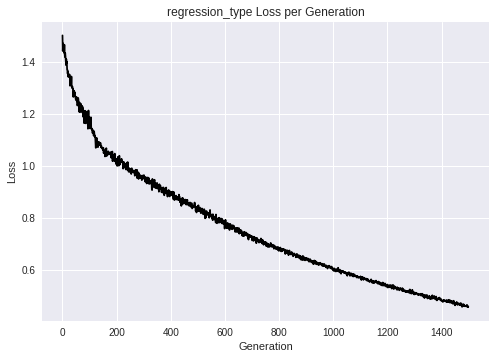

1 0.8982630272952854


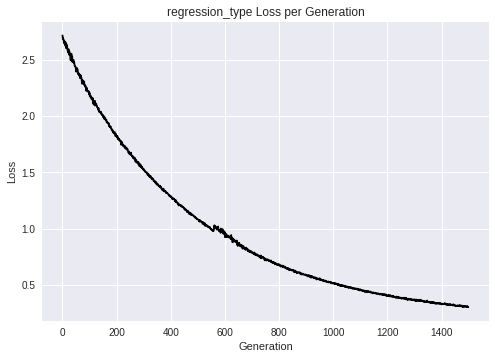

2 0.8709677419354839


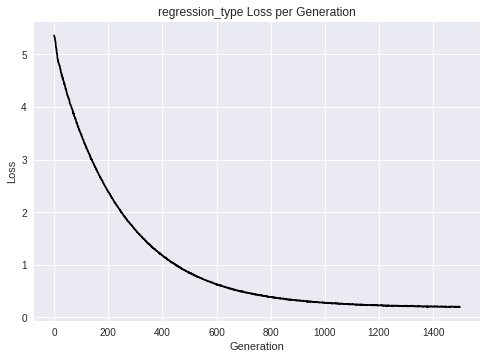

3 0.7369727047146402


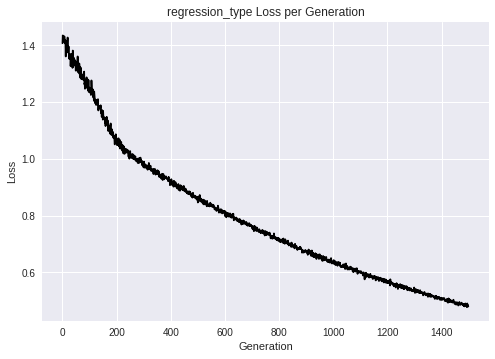

4 0.8461538461538461


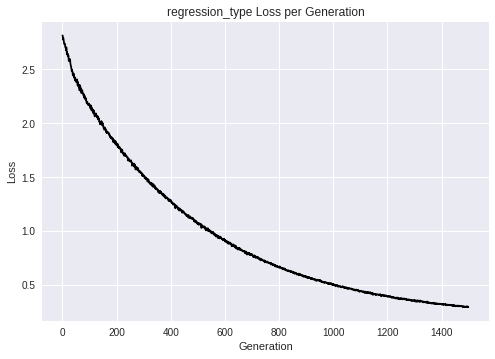

5 0.6129032258064517


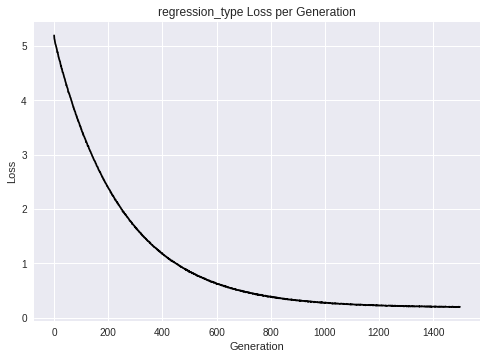

6 0.8908188585607941


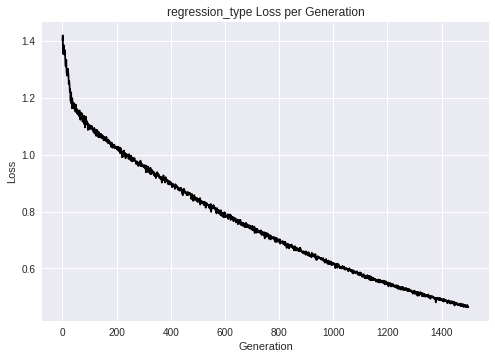

7 0.8560794044665012


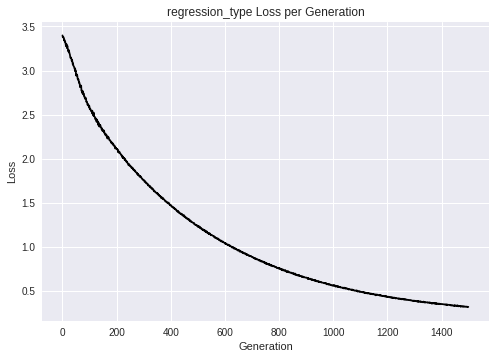

8 0.9205955334987594


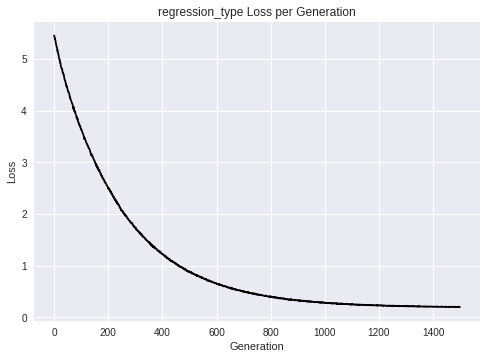

9 0.6203473945409429


In [72]:
lambda_thetas, lambda_betas = [.5,.75,1.], [1.,2.5,5.]
#step_thetas, step_betas = [.5,1e-1,1e-2,1e-4], [.5,1e-1,1e-2,1e-4]
results1 = {}
i = 1
for lamb_th in lambda_thetas:
  for lamb_be in lambda_betas:
    params = it_reg(y=y,counts=counts,vec_weights=np_cos_sim,cui_subset=np_cui_subset,val_perc = 0.1,lambda_theta=lamb_th,lambda_beta=lamb_be)
    y_test_preds = predict(counts=test_counts,vec_weights=np_cos_sim,cui_subset=np_cui_subset,
                       theta=params['theta'],beta=params['beta'],beta0=params['beta0'])
    test_auc = metrics.roc_auc_score(test_y, y_test_preds)
    results1['lamb_th'+str(lamb_th)+'lamb_be'+str(lamb_be)] = {'results':params,'test_auc':test_auc}
    print(i,test_auc)
    i += 1
        

In [74]:
for k in results1.keys():
  print(results1[k]['test_auc'])
results1.keys()  

0.8982630272952854
0.8709677419354839
0.7369727047146402
0.8461538461538461
0.6129032258064517
0.8908188585607941
0.8560794044665012
0.9205955334987594
0.6203473945409429


dict_keys(['lamb_th0.5lamb_be1.0', 'lamb_th0.5lamb_be2.5', 'lamb_th0.5lamb_be5.0', 'lamb_th0.75lamb_be1.0', 'lamb_th0.75lamb_be2.5', 'lamb_th0.75lamb_be5.0', 'lamb_th1.0lamb_be1.0', 'lamb_th1.0lamb_be2.5', 'lamb_th1.0lamb_be5.0'])

In [29]:
list(results.keys())[24]

'lamb_th10.0lamb_be10.0'

In [30]:
print(results['lamb_th0.1lamb_be5.0']['test_auc'])
print(results['lamb_th0.1lamb_be10.0']['test_auc'])
print(results['lamb_th1.0lamb_be10.0']['test_auc'])
print(results['lamb_th10.0lamb_be10.0']['test_auc'])

0.9379652605459058
0.9106699751861043
0.9230769230769231
0.9156327543424317


In [28]:
for k in results2.keys():
  print(results2[k]['test_auc'])

0.27543424317617865
0.5459057071960298
0.8064516129032258
0.7220843672456576
0.7394540942928041
0.8039702233250621
0.6253101736972705
0.9255583126550868
0.4764267990074442
0.8635235732009925
0.6972704714640199
0.7965260545905707
0.7568238213399503
0.9305210918114144
0.56575682382134
0.7320099255583127
0.739454094292804
0.652605459057072
0.32754342431761785
0.630272952853598
0.707196029776675
0.6600496277915633
0.7220843672456575
0.6947890818858561
0.7369727047146402


In [29]:
results2.keys()

dict_keys(['lamb_th0.1lamb_be0.1', 'lamb_th0.1lamb_be0.5', 'lamb_th0.1lamb_be1.0', 'lamb_th0.1lamb_be5.0', 'lamb_th0.1lamb_be10.0', 'lamb_th0.5lamb_be0.1', 'lamb_th0.5lamb_be0.5', 'lamb_th0.5lamb_be1.0', 'lamb_th0.5lamb_be5.0', 'lamb_th0.5lamb_be10.0', 'lamb_th1.0lamb_be0.1', 'lamb_th1.0lamb_be0.5', 'lamb_th1.0lamb_be1.0', 'lamb_th1.0lamb_be5.0', 'lamb_th1.0lamb_be10.0', 'lamb_th5.0lamb_be0.1', 'lamb_th5.0lamb_be0.5', 'lamb_th5.0lamb_be1.0', 'lamb_th5.0lamb_be5.0', 'lamb_th5.0lamb_be10.0', 'lamb_th10.0lamb_be0.1', 'lamb_th10.0lamb_be0.5', 'lamb_th10.0lamb_be1.0', 'lamb_th10.0lamb_be5.0', 'lamb_th10.0lamb_be10.0'])

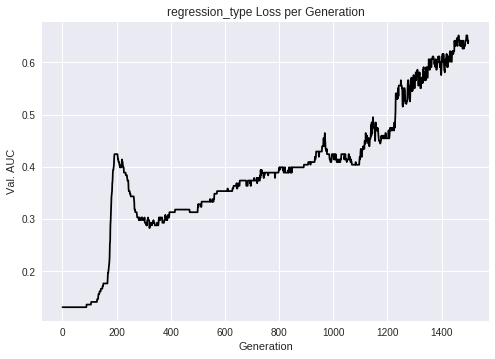

0.6515151515151515

In [40]:

plt.plot(results2['lamb_th0.5lamb_be1.0']['results']['valAUC'], 'k-')
plt.title('regression_type' + ' Loss per Generation')
plt.xlabel('Generation')
plt.ylabel('Val. AUC')
plt.show()
np.max(results2['lamb_th0.5lamb_be1.0']['results']['valAUC'])

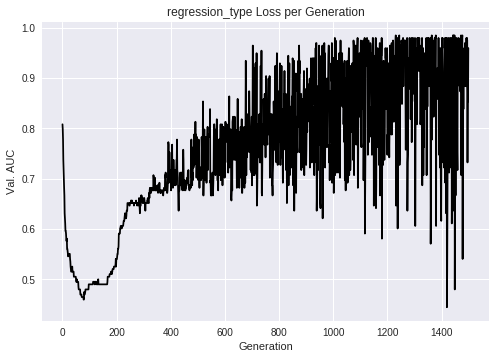

0.9848484848484849

In [46]:
plt.plot(results2['lamb_th1.0lamb_be5.0']['results']['valAUC'], 'k-')
plt.title('regression_type' + ' Loss per Generation')
plt.xlabel('Generation')
plt.ylabel('Val. AUC')
plt.show()
np.max(results2['lamb_th1.0lamb_be5.0']['results']['valAUC'])
